In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

For this lab, we will use the iris dataset (https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), which can be directly downloaded from scikit-learn.

It contains N=150 data points about K=3 different types of iris flowers (setosa, versicolor, and virginica). Each point has D=4 dimension, representing the sepal length, the sepal width, the petal length and the petal width (in centimeters).

In [2]:
# Import and download the dataset
from sklearn import datasets

iris_dataset = datasets.load_iris()

In [3]:
# Define features as X and targets as y
X_iris, y_iris = iris_dataset.data, iris_dataset.target
print(X_iris.shape, y_iris.shape)

(150, 4) (150,)


We have a float array of features X_iris of size N x D, where N is the number of points and D the dimensionality of the features, and an integer array of labels y_iris of size N.

Let's quickly visualize this dataset using only the first two dimensions.

In [4]:
# We create a custom "colormap" so that elements with label 0 have color blue,
# elements with label 1 have color red and elements with label 2 have color green in our figure below.
from matplotlib.colors import ListedColormap

colormap = ListedColormap(['blue', 'red', 'green'])

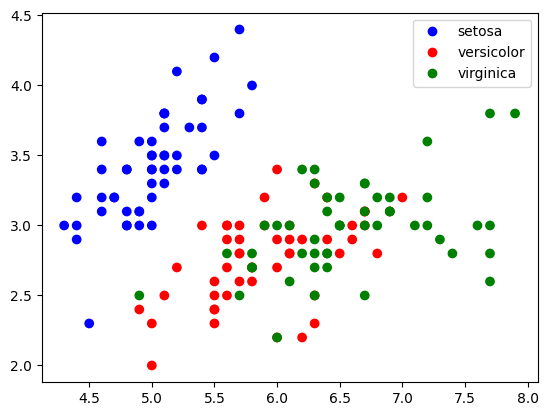

In [5]:
# 2D scatter plot of the dimensions 2 and 3 of the dataset
scatter = plt.scatter(X_iris[:,0], X_iris[:,1], c=y_iris, cmap=colormap)
plt.legend(scatter.legend_elements()[0], iris_dataset.target_names)
plt.show()

# Unsupervised learning

For now let's assume we don't have access to the labels *y_iris*, and see if we can still identify some structure in the dataset.

## K-Means

**Implement the K-Means algorithm and run it on the whole iris dataset using K=3.**

In [47]:
def k_means_cluster(dataset, k):
    # Initialization: choose k centroids using the Forgy method (random points)
    random_indexes = np.random.choice(dataset.shape[0], size=k, replace=False)
    centroids = X_iris[random_indexes]
    
    # Initialize clusters list
    clusters = [[] for _ in range(k)]
    
    # Loop until convergence
    converged = False
    while not converged:
        # Clear previous clusters
        clusters = [[] for _ in range(k)]
    
        # Assign each point to the "closest" centroid 
        for point in dataset:
            distances_to_each_centroid = [np.linalg.norm(point - centroid) for centroid in centroids]
            cluster_assignment = np.argmin(distances_to_each_centroid)
            clusters[cluster_assignment].append(point)
        
        # Calculate new centroids
        #   (the standard implementation uses the mean of all points in a
        #     cluster to determine the new centroid)
        new_centroids = np.array([np.mean(cluster, axis = 0) for cluster in clusters])
        converged = np.array_equal(new_centroids, centroids)
        centroids = new_centroids
        
        if converged:
            points = np.vstack(clusters)
            labels = np.concatenate([[i + 1] * len(cluster) for i, cluster in enumerate(clusters)])

            return points, labels

In [48]:
k_means_cluster, labels = k_means_cluster(X_iris, 3)

**Display only the first 2 dimensions as in the figure above, with color points based on their assigned clusters. Do you have a result consistent with the true flower categories?**

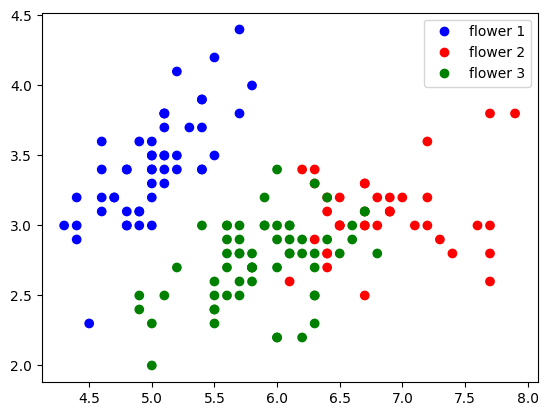

In [53]:
scatter = plt.scatter(k_means_cluster[:,0], k_means_cluster[:,1], c=labels, cmap=colormap)
plt.legend(scatter.legend_elements()[0], ['flower 1', 'flower 2', 'flower 3'])
plt.show()

Now you may use the scikit-learn implementation sklearn.cluster.KMeans if you wish (you don't have to, but it will probably be easier with this class).

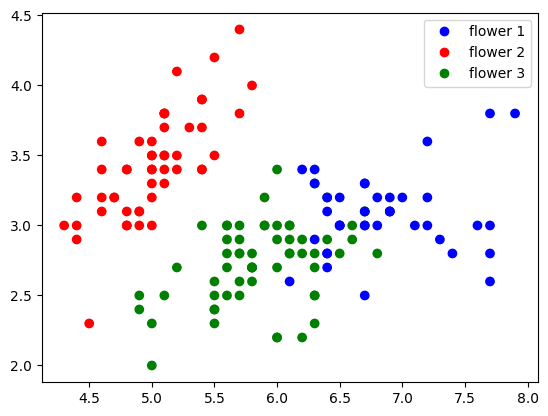

In [55]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_iris)

scatter = plt.scatter(X_iris[:,0], X_iris[:,1], c=kmeans.labels_, cmap=colormap)
plt.legend(scatter.legend_elements()[0], ['flower 1', 'flower 2', 'flower 3'])
plt.show()

**Plot the "inertia" with respect to the number of clusters after running KMeans with different numbers of clusters. Here, "inertia" means the objective $\sum_{n=1}^N \lVert \mathbf{x}_n - \mathbf{c}_{a(\mathbf{x}_n)}\rVert_2^2$**

You don't have to compute the inertia manually, there is a way to obtain it directly if you look at the documentation of the class sklearn.cluster.KMeans

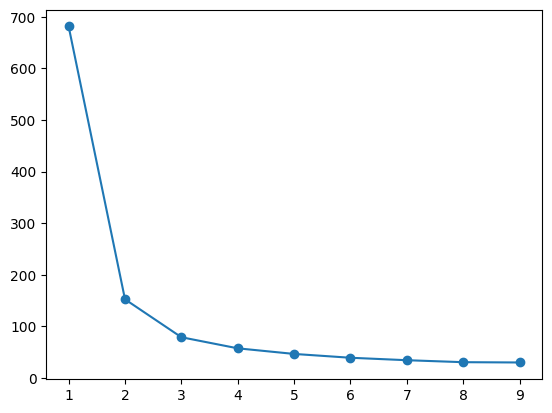

In [65]:
inertia_values = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_iris)
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker='o')

**If we didn't know how many clusters we needed, could we infer this number from this figure?**

To determine the optimal number of clusters with the "elbow" method, we have to select the value of k at the point after which the distortion/inertia starts decreasing in a linear fashion. In this we could have inferred the number 3 from the figure.

**Did you think about running KMeans several times to make sure we don't obtain different results (and thus different inertia) for a given number of clusters?**

Of couoourse I diddd !! :)

Don't actually bother showing me that you did, it won't be graded anyway. But ideally, this is something that you should have thought about.

## Not K-Means

Let's get a new (generated) dataset.

In [68]:
X_moons, y_moons = sklearn.datasets.make_moons(n_samples=200, shuffle=True, noise=0.05, random_state=42)

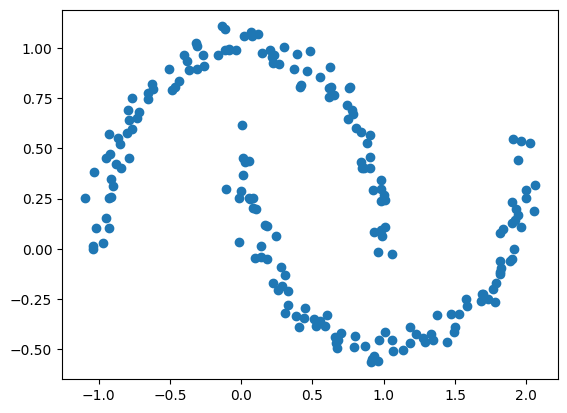

In [69]:
plt.scatter(X_moons[:,0], X_moons[:,1])
plt.show()

**How many groups of points would a human probably intuitively identify here?**

Two.

**Run K-Means on this dataset with the number of clusters you suggested.**

(To display the result with a code similar to previously, you may need to define a new colormap with only two colors).

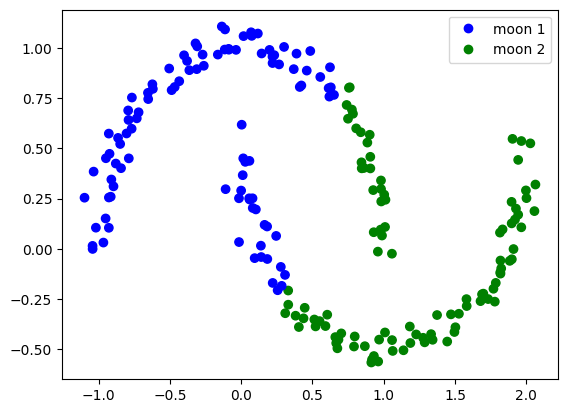

In [81]:
moons_kmeans = KMeans(n_clusters=2, random_state=42)
moons_kmeans.fit(X_moons)

scatter = plt.scatter(X_moons[:,0], X_moons[:,1], c=moons_kmeans.labels_, cmap=colormap)
plt.legend(scatter.legend_elements()[0], ['moon 1', 'moon 2'])
plt.show()

**Are the "intuitive" clusters correctly identified? Why?**

No thee two clusters are not correctly identified. The reason is that the points are not linearly separable. There is no line that could split in two parts the space to correctly classify all the points.

In a future class (and lab), we will cover other clustering algorithms that may be more suitable for situations like this.

# Supervised learning

## K-nearest neighbors

Now let's go back to our Iris dataset. Remember that until now, we have not used *y_iris* (defined in the 3rd cell of this notebook), as in an unsupervised learning setting, we don't have access to labels.

Let's now switch to a supervised learning setting.

First, let's divide the data into a training set, that we will use as a reference to make predictions, and a testing set, for which we wish to make predictions.

If you look at the labels, you can see that they are sorted. We will thus start by shuffling the dataset, so that we do not have only 1 class in the testing set.

In [85]:
from sklearn.utils import shuffle

X_iris_shuffled, y_iris_shuffled = shuffle(X_iris, y_iris, random_state=42)

Now, let's use for example the first 100 elements of the dataset and their labels  as training points, and the last 50 as testing points.

**Divide the dataset into a training set and a testing set.**

In [86]:
X_train = X_iris_shuffled[:100]
y_train = y_iris_shuffled[:100]

X_test = X_iris_shuffled[100:]
y_test = y_iris_shuffled[100:]

**Implement a B-nearest neighbor classifier, that uses the training set as reference points and can be used to make predict the class of the testing set.**

(I called it a B-nearest neighbor classifier as opposed to K-nearest neighbor in order not to induce confusion with the K for K-Means, it is not the same thing at all in this context.)

You may use a number of neighbors B=3 if it's more convenient.

In [88]:
def b_nearest_neighbors(X_train, y_train, X_test, b=3):
    """Implement the b-nearest neighbor algorithm."""
    y_pred = []  # To store predictions for each test point

    # Loop over all test points
    for test_point in X_test:
        # Calculate distances from test_point to all training points
        distances = [np.linalg.norm(test_point - train_point) for train_point in X_train]
        
        # Get the indices of the b nearest neighbors
        nearest_indices = np.argsort(distances)[:b]
        
        # Get the labels of the b nearest neighbors
        nearest_labels = [y_train[i] for i in nearest_indices]
        
        # Predict the label as the most common label among the nearest neighbors
        unique_labels, counts = np.unique(nearest_labels, return_counts=True)
        most_common_label = unique_labels[np.argmax(counts)]
        y_pred.append(most_common_label)

    return np.array(y_pred)

**Use your classifier to predict the classes of the 50 samples in the testing set.**

**Compare these predictions with actual answers, the labels in the testing set. What is the accuracy, i.e. the percentage of correct predictions?**

In [91]:
y_pred = b_nearest_neighbors(X_train, y_train, X_test, 3)

print("Predicted labels:", y_pred)
print("True labels:     ", y_test)

# Evaluate accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Predicted labels: [0 0 0 2 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2
 2 1 2 1 1 2 2 0 1 1 0 1 2]
True labels:      [0 0 0 1 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2
 2 1 2 1 1 2 2 0 1 2 0 1 2]
Accuracy: 96.00%


**Do the same thing, this time using the sklearn classifier. Do you get a comparable result?**

In [94]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

y_pred_sklearn = neigh.predict(X_test)
print("Predicted labels using sklearn:", y_pred_sklearn)
print("True labels:                   ", y_test)

# Evaluate accuracy
accuracy = np.sum(y_pred_sklearn == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Predicted labels using sklearn: [0 0 0 2 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2
 2 1 2 1 1 2 2 0 1 1 0 1 2]
True labels:                    [0 0 0 1 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2
 2 1 2 1 1 2 2 0 1 2 0 1 2]
Accuracy: 96.00%


**You (should have) obtained a fairly good result. Is machine learning that simple?**

I will answer this one for you: in general, **no**.

This was a "toy" dataset, that was extremely simple (after all, this was the first class of machine learning). In reality, most problems you are likely to work on are much more complex.

As an example, let's try using the same approach on an another dataset available from the Olivetti faces dataset (https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset)

In [95]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /Users/marioroca/scikit_learn_data


It represents faces of different people as arrays/vectors of pixels. Let's have a look at a couple of examples (don't bother too much with the code below, this is just to show you a more difficult problem).

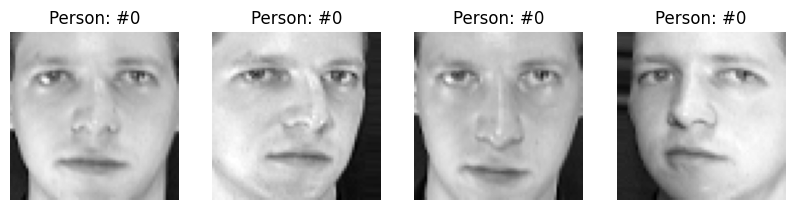

In [96]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, faces.images, faces.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title("Person: #%i" % label)

The 4 images above are 4 distinct photographs of the same person, labeled person 0.

Let's again divide the dataset into a train/test split, and use a nearest neighbors classifier to make predictions.

In [97]:
from sklearn.model_selection import train_test_split

# I suffle and split my dataset at the same time
X_train, X_test, y_train, y_test = train_test_split(
    faces.data, faces.target, test_size=0.5, shuffle=True, random_state=42
)

In [98]:
# We "train" the classifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [99]:
accuracy = clf.score(X_test, y_test)
print(f"Accuracy: {accuracy*100}%")

Accuracy: 71.5%


To be honest, this is already quite good, and actually much better than what I was expecting before running this code.

However, I wouldn't really want a system that has a 30% chance of failure of misidentify people to screen passengers at an airport. Depending on the application, even a 0.1% of failure may be too much. For example, I would not want my autonomous car to have a 0.1% chance of running a red light.

So (un?)fortunately, it looks like our machine learning journey is not over yet.

See you next class.